# Facial Emotion Recognition | VGG19 Model


## Library

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mlflow

In [1]:
import math
import numpy as np
import pandas as pd
import random
import os

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Data Collection Combining and Saving

### Setting directories

In [ ]:
train_data_dir = r"C:/Users/Ghost/Desktop/gits/Emotion-Based-Music-Recommendation/training/datasets/train/"
test_data_dir = r"C:/Users/Ghost/Desktop/gits/Emotion-Based-Music-Recommendation/training/datasets/test/"

### Collect images from each train and test dataset and save it into a numpy array

In [ ]:
def collect_data(directory):
    data = []
    labels = []

    total = 0

    for index, label  in enumerate(os.listdir(directory)):

        for image_file in os.listdir(os.path.join(directory, label)):

            img = cv2.imread(os.path.join(os.path.join(directory, label, image_file)))

            data.append(img)
            labels.append(label)

            total += 1

    print(f'Total data saved = {total}')
    return data,labels

In [ ]:
final_data = []
final_labels = []

# Getting train_datas
print("Train Datas")

train_data, train_labels = collect_data(train_data_dir)
final_data.extend(train_data)
final_labels.extend(train_labels)

# Getting test_datas
print("Test Datas")

test_data, test_labels = collect_data(test_data_dir)
final_data.extend(test_data)
final_labels.extend(test_labels)


### Shuffle

In [ ]:
combined_list = list(zip(final_data,final_labels))
shuffled_combined_list = random.sample(combined_list,len(combined_list))

final_data,final_labels = zip(*shuffled_combined_list)

In [ ]:
data = np.array(final_data)
labels = np.array(final_labels)

### Saving to .npy file so we can load datasets later

In [ ]:
np.save("data_numpy/emotion_data.npy",data)
np.save("data_numpy/emotion_labels.npy",labels)

In [2]:
data = np.load('data_numpy/emotion_data.npy')
labels = np.load('data_numpy/emotion_labels.npy')

# Visualization

### Visualizing Labels

In [3]:
categories = ['angry','disgust','fear','happy','neutral','sad','surprise']

Total Number of Images : 35887


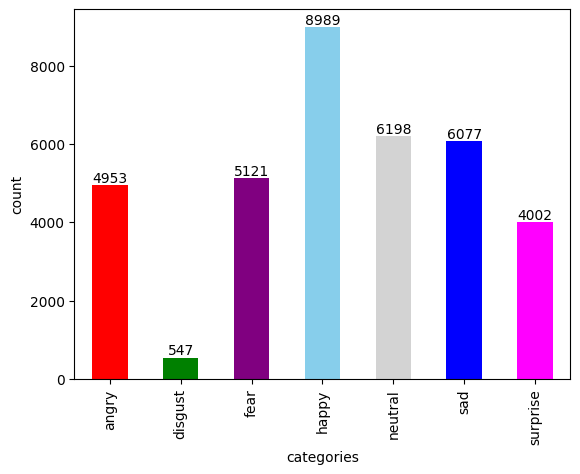

In [4]:
# Total Numer of Images
print(f"Total Number of Images : {len(labels)}")

# For coloring purposes
color_map = {'angry' : 'red','disgust' : 'green','fear' : 'purple','happy' : 'skyblue','neutral' : 'lightgray','sad' : 'blue','surprise' : 'magenta'}

# Plotting bar graph
label_series = pd.Series(labels)
ax = label_series.value_counts().sort_index(ascending=True).plot(kind="bar",color=[color_map[x] for x in categories],xlabel='categories',ylabel='count');

for bar in ax.patches:
    ax.annotate(str(bar.get_height()), (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                ha='center', va='bottom')


### Visualizing Images

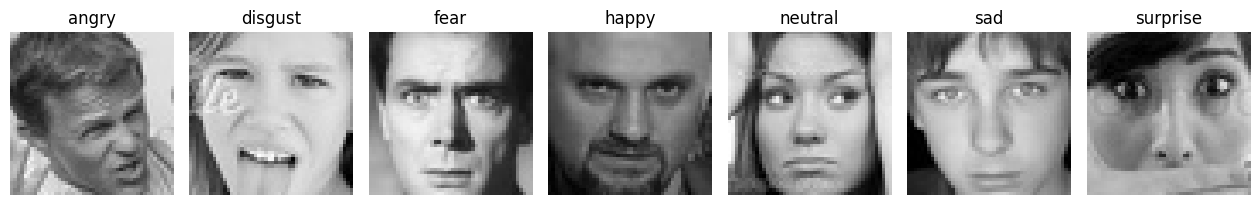

In [5]:
def random_value_for_index(list, target_value):
    indices = [index for index,value in enumerate(list) if value == target_value]
    return random.choice(indices)

fig, axs = plt.subplots(1,7 ,figsize=(16,16))

for index,category in enumerate(categories):
    # Select random image index from specific category
    random_index = random_value_for_index(labels,category)

    # Plot the random image
    axs[index].imshow(data[random_index])
    axs[index].axis('off')
    axs[index].set_title(category)

plt.subplots_adjust(wspace = 0.1,hspace = 0.1)
plt.show()

### Splitting the data into training and validation set.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(data,
                                                      labels,
                                                      shuffle = True,
                                                      test_size = 0.2,
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709,), (7178,))

In [48]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

In [49]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = 7

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [50]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [51]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights. This is a technique often used in transfer learning applications.

In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem. In this way, it may be possible to obtain better results using less data.

In [40]:
# for layer in vgg.layers:
    # layer.trainable = False

In [52]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [53]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)

    return model

In [54]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [55]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               min_delta = 0.00005,
                               patience = 11,
                               verbose = 1,
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 factor = 0.5,
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [56]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [57]:
# batch size of 32 performs the best.
batch_size = 32
epochs = 100
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [58]:
history = model.fit(train_datagen.flow(X_train,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/100
897/897 [==============================] - 68s 67ms/step - loss: 1.5097 - accuracy: 0.4048 - val_loss: 1.2391 - val_accuracy: 0.5224 - lr: 1.0000e-04
Epoch 2/100
897/897 [==============================] - 59s 65ms/step - loss: 1.2520 - accuracy: 0.5179 - val_loss: 1.1623 - val_accuracy: 0.5645 - lr: 1.0000e-04
Epoch 3/100
897/897 [==============================] - 58s 65ms/step - loss: 1.1704 - accuracy: 0.5568 - val_loss: 1.0858 - val_accuracy: 0.5901 - lr: 1.0000e-04
Epoch 4/100
897/897 [==============================] - 61s 68ms/step - loss: 1.1145 - accuracy: 0.5800 - val_loss: 1.0525 - val_accuracy: 0.6074 - lr: 1.0000e-04
Epoch 5/100
897/897 [==============================] - 61s 67ms/step - loss: 1.0703 - accuracy: 0.5995 - val_loss: 1.0718 - val_accuracy: 0.5974 - lr: 1.0000e-04
Epoch 6/100
897/897 [==============================] - 59s 66ms/step - loss: 1.0257 - accuracy: 0.6148 - val_loss: 1.0261 - val_accuracy: 0.6162 - lr: 1.0000e-04
Epoch 7/100
897/897 [=======

# Save Logs

In [59]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('logs/training_history.csv', index=False)

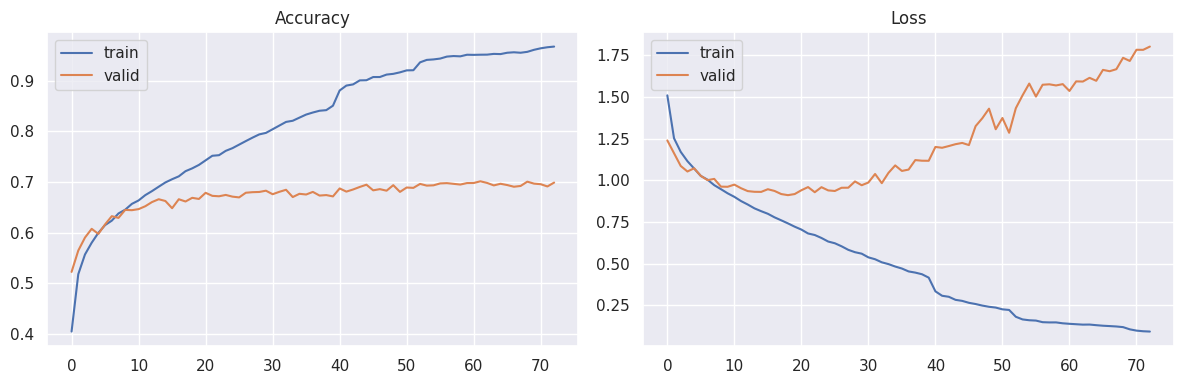

In [60]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# plt.savefig('epoch_history_dcnn.png')
plt.show()


# Save Model

In [61]:
model.save('models/vgg.h5')

# Load Model

In [23]:
model = tf.keras.models.load_model('models/vgg.h5')

# Metrices

In [ ]:
import numpy as np

# Get predictions from your model
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = label_encoder.transform(y_valid)

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_valid, y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

       angry       0.29      0.53      0.37       978
     disgust       0.00      0.00      0.00       109
        fear       0.24      0.22      0.23       991
       happy       0.76      0.67      0.71      1816
     neutral       0.41      0.41      0.41      1271
         sad       0.50      0.09      0.15      1250
    surprise       0.31      0.55      0.40       763

    accuracy                           0.42      7178
   macro avg       0.36      0.35      0.32      7178
weighted avg       0.46      0.42      0.40      7178



<Axes: >

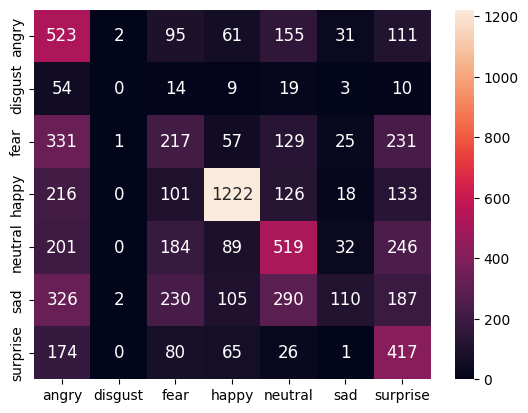

In [50]:
cf_matrix = confusion_matrix(y_valid, y_pred_classes)
cm_array_df = pd.DataFrame(cf_matrix, index=categories, columns=categories)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12},fmt=".0f") 

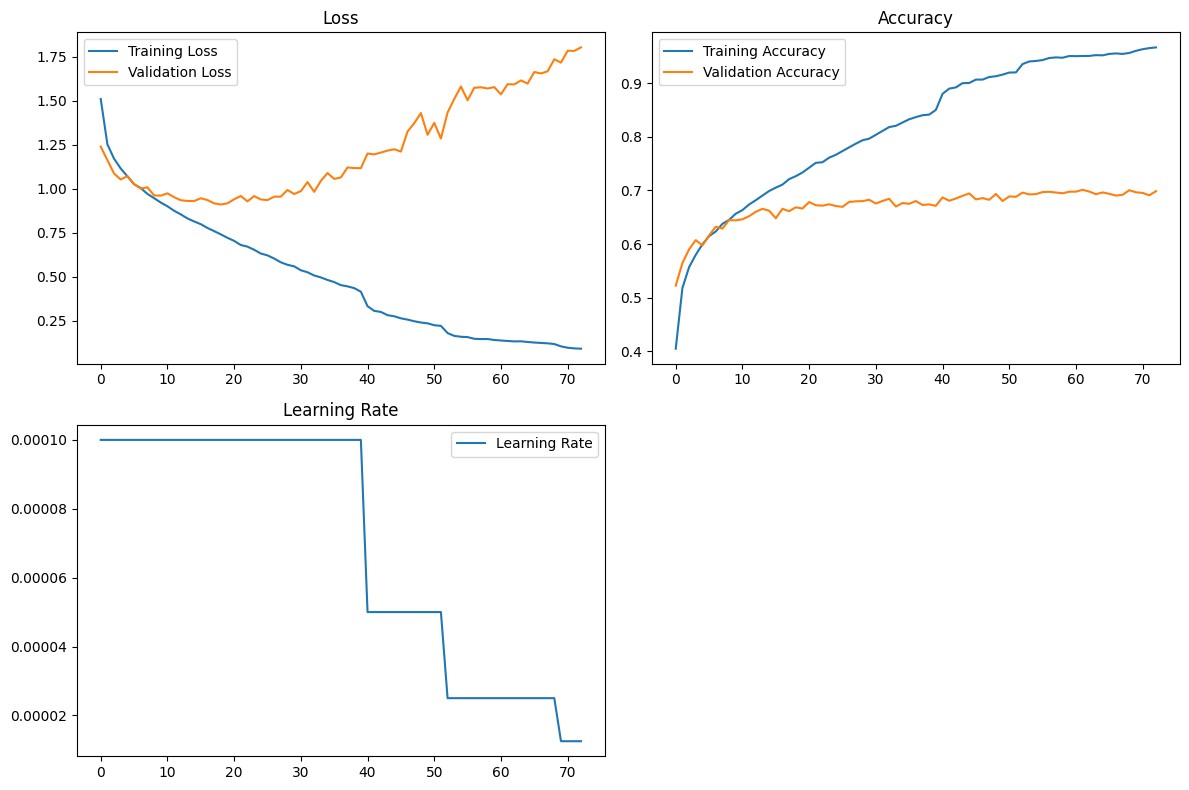

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
history_df = pd.read_csv('training_history_vgg.csv')  # Replace 'your_history.csv' with your actual file name

# Extract relevant columns
train_loss = history_df['loss']
train_accuracy = history_df['accuracy']
val_loss = history_df['val_loss']
val_accuracy = history_df['val_accuracy']
lr = history_df['lr']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot loss
axes[0, 0].plot(history_df.index, train_loss, label='Training Loss')
axes[0, 0].plot(history_df.index, val_loss, label='Validation Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()

# Plot accuracy
axes[0, 1].plot(history_df.index, train_accuracy, label='Training Accuracy')
axes[0, 1].plot(history_df.index, val_accuracy, label='Validation Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()

# Plot learning rate
axes[1, 0].plot(history_df.index, lr, label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].legend()

# Remove the empty subplot
fig.delaxes(axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()
